In [197]:
# 导包
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split

In [198]:
# 读取数据
# 根据题意，先把header设置好
headers = ['age', 'workclass', 'fnlwgt',
           'education', 'education_num', 'marital_status',
           'occupation', 'relationship', 'race',
           'sex', 'capital_gain', 'capital_loss',
           'hours_per_week', 'native_country', 'income']

# 读取训练集进入内存
train_data = pd.read_csv("data/adult_train.csv",names=headers)

# 对于测试集，他的第一行是一个分隔，不读入
test_data = pd.read_csv("data/adult_test.csv",names=headers,skiprows=[0])

In [199]:
# 查看各类数据类型
train_data.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education_num      int64
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain       int64
capital_loss       int64
hours_per_week     int64
native_country    object
income            object
dtype: object

In [200]:
# 看看训练集有多少数据
train_data.shape

(32561, 15)

In [201]:
# 看看数据是怎么样的，平均值；最大最小值，标准差等等（只有连续性的）
train_data.describe()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [202]:
# 数据中有一些值是？，用python的NaN代替方便以后直接当作空值处理
train_data = train_data.replace('[?]', np.NaN, regex=True)
test_data = test_data.replace('[?]', np.NaN, regex=True)
# 看看数据里有NaN的各类有多少
train_data.isnull().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education_num        0
marital_status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital_gain         0
capital_loss         0
hours_per_week       0
native_country     583
income               0
dtype: int64

In [203]:
# 对于缺失属性的数据直接删除
train_data = train_data.dropna()
train_data.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income            0
dtype: int64

In [204]:
# 开始处理离散数据
# income我们需要将其映射一下
# 先将>=50K的映射成0，<=50K的设置为1
income_map = {' <=50K':1,' >50K':0}
income_map2 = {' <=50K.':1, ' >50K.':0}
train_data['income'] = train_data['income'].map(income_map).astype(int)
test_data['income'] = test_data['income'].map(income_map2).astype(int)


In [205]:
# 取出所有的离散量属性
discrete = [x for x in train_data.columns if train_data[x].dtype=='object']
discrete

['workclass',
 'education',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native_country']

In [206]:
# 看看这些离散量属性的取值分布
for i in discrete:
    print(train_data[i].value_counts())
    

 Private             22286
 Self-emp-not-inc     2499
 Local-gov            2067
 State-gov            1279
 Self-emp-inc         1074
 Federal-gov           943
 Without-pay            14
Name: workclass, dtype: int64
 HS-grad         9840
 Some-college    6678
 Bachelors       5044
 Masters         1627
 Assoc-voc       1307
 11th            1048
 Assoc-acdm      1008
 10th             820
 7th-8th          557
 Prof-school      542
 9th              455
 12th             377
 Doctorate        375
 5th-6th          288
 1st-4th          151
 Preschool         45
Name: education, dtype: int64
 Married-civ-spouse       14065
 Never-married             9726
 Divorced                  4214
 Separated                  939
 Widowed                    827
 Married-spouse-absent      370
 Married-AF-spouse           21
Name: marital_status, dtype: int64
 Prof-specialty       4038
 Craft-repair         4030
 Exec-managerial      3992
 Adm-clerical         3721
 Sales                3584
 Othe

In [207]:
# 发现有一些是比较接近重叠的，将这些重叠的归到同一类
# 大致可以把gov有关的一类，Private一类，Self-emp一类，没工作的一类
train_data['workclass'] = train_data['workclass'].replace([' Self-emp-not-inc', ' Self-emp-inc'],' Self-emp')
train_data['workclass'] = train_data['workclass'].replace([' Federal-gov', ' Local-gov', ' State-gov'], ' Gov')
train_data['workclass'] = train_data['workclass'].replace([' Without-pay', ' Never-worked'], ' Un-emp')
train_data['workclass'].value_counts()                                                         

test_data['workclass'] = test_data['workclass'].replace([' Self-emp-not-inc', ' Self-emp-inc'],' Self-emp')
test_data['workclass'] = test_data['workclass'].replace([' Federal-gov', ' Local-gov', ' State-gov'], ' Gov')
test_data['workclass'] = test_data['workclass'].replace([' Without-pay', ' Never-worked'], ' Un-emp')

In [208]:
# 同理对marital_status进行归类
train_data['marital_status'] = train_data['marital_status'].replace([' Divorced',' Married-spouse-absent',' Never-married',' Separated',' Widowed'],' Single')
train_data['marital_status'] = train_data['marital_status'].replace([' Married-civ-spouse', ' Married-AF-spouse'], ' Couple')
train_data['marital_status'].value_counts()

test_data['marital_status'] = test_data['marital_status'].replace([' Divorced',' Married-spouse-absent',' Never-married',' Separated',' Widowed'],' Single')
test_data['marital_status'] = test_data['marital_status'].replace([' Married-civ-spouse', ' Married-AF-spouse'], ' Couple')

In [209]:
# native_country这个分类太多了，而且很多类的人很少，干脆把人少的都归到other里
train_data['native_country'] = train_data['native_country'].replace([' Holand-Netherlands',' Scotland', ' Honduras', 
                                                                     ' Hungary', ' Outlying-US(Guam-USVI-etc)', ' Yugoslavia', 
                                                                     ' Laos', ' Thailand', ' Cambodia', 
                                                                     ' Trinadad&Tobago', ' Hong', ' Ireland', 
                                                                     ' France',' Ecuador', ' Greece', ' Peru', 
                                                                     ' Nicaragua', ' Portugal', ' Iran', 
                                                                     ' Taiwan', ' Haiti'], ' Other')

test_data['native_country'] = test_data['native_country'].replace([' Holand-Netherlands',' Scotland', ' Honduras', 
                                                                     ' Hungary', ' Outlying-US(Guam-USVI-etc)', ' Yugoslavia', 
                                                                     ' Laos', ' Thailand', ' Cambodia', 
                                                                     ' Trinadad&Tobago', ' Hong', ' Ireland', 
                                                                     ' France',' Ecuador', ' Greece', ' Peru', 
                                                                     ' Nicaragua', ' Portugal', ' Iran', 
                                                                     ' Taiwan', ' Haiti'], ' Other')
train_data['native_country'].value_counts()

 United-States         27504
 Mexico                  610
 Other                   486
 Philippines             188
 Germany                 128
 Puerto-Rico             109
 Canada                  107
 El-Salvador             100
 India                   100
 Cuba                     92
 England                  86
 Jamaica                  80
 South                    71
 China                    68
 Italy                    68
 Dominican-Republic       67
 Vietnam                  64
 Guatemala                63
 Japan                    59
 Poland                   56
 Columbia                 56
Name: native_country, dtype: int64

In [210]:
# 最后，看看education_num这个连续量
train_data['education'].value_counts()

 HS-grad         9840
 Some-college    6678
 Bachelors       5044
 Masters         1627
 Assoc-voc       1307
 11th            1048
 Assoc-acdm      1008
 10th             820
 7th-8th          557
 Prof-school      542
 9th              455
 12th             377
 Doctorate        375
 5th-6th          288
 1st-4th          151
 Preschool         45
Name: education, dtype: int64

In [211]:
# 发现跟education一样的，重复了，因为eudcation是离散的，不好处理。去掉这个属性
train_data = train_data.drop(columns=['education'])
test_data = test_data.drop(columns=['education'])

In [212]:
# 看看相关系数矩阵,检查一下连续变量。发现序号属性不太影响最后的收入
train_data.corr()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,income
age,1.000000,-0.076511,0.043526,0.080154,0.060165,0.101599,-0.241998
fnlwgt,-0.076511,1.000000,-0.044992,0.000422,-0.009750,-0.022886,0.008957
education_num,0.043526,-0.044992,1.000000,0.124416,0.079646,0.152522,-0.335286
capital_gain,0.080154,0.000422,0.124416,1.000000,-0.032229,0.080432,-0.221196
capital_loss,0.060165,-0.009750,0.079646,-0.032229,1.000000,0.052417,-0.150053
hours_per_week,0.101599,-0.022886,0.152522,0.080432,0.052417,1.000000,-0.229480
income,-0.241998,0.008957,-0.335286,-0.221196,-0.150053,-0.229480,1.000000


In [213]:
# 把序号属性删掉
train_data = train_data.drop(columns=['fnlwgt'])
test_data = test_data.drop(columns=['fnlwgt'])

In [214]:
# 再次取离散量和连续量类别以备后用
discrete = [x for x in train_data.columns if train_data[x].dtype=='object']
continues = [x for x in train_data.columns if train_data[x].dtype=='int64']

In [215]:
# 进行one-hot编码
train_data = pd.get_dummies(train_data, columns=['workclass', 'marital_status', 'occupation',
                                                 'relationship', 'race', 'sex',
                                                 'native_country'])

test_data = pd.get_dummies(test_data, columns=['workclass', 'marital_status', 'occupation',
                                                 'relationship', 'race', 'sex',
                                                 'native_country'])

In [216]:
# 因为使用的模型是决策树，无需进行标准化
# 把要预测的值income单独拿出来
# 当作结果
y_total = train_data.income
x_total = train_data.drop('income', axis=1)

# 分割出训练集和交叉验证集
# stratiy=y_total确保分割后的比例分布与原数据一致
x_train, x_eval, y_train, y_eval = train_test_split(x_total, y_total, test_size=0.2, 
                                                    stratify=y_total) 

y_test = test_data.income
x_test = test_data.drop('income', axis=1)

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(24129, 59)
(24129,)
(16281, 59)
(16281,)


In [217]:
# 参数，官方文档给出的如下
"""
    (boosting_type='gbdt', num_leaves=31, max_depth=-1, 
    learning_rate=0.1, n_estimators=100, subsample_for_bin=200000, 
    objective=None, class_weight=None, min_split_gain=0.0, 
    min_child_weight=0.001, min_child_samples=20, subsample=1.0, 
    subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, 
    reg_lambda=0.0, random_state=None, n_jobs=-1, 
    silent=True, importance_type='split', **kwargs)
"""

# 由于lightGBM是leaves_wise生长，官方说法是要num_leaves小于2^max_depth

paras = {
    'num_leaves':100,
    'max_depth':8,
    'learning_rate':0.05
}

# 定义模型并开始训练
lgbm = LGBMClassifier()
lgbm.fit(x_train, y_train, eval_set=(x_eval, y_eval), eval_metric='l1', early_stopping_rounds=5)
 

[1]	valid_0's l1: 0.356201	valid_0's binary_logloss: 0.516975
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l1: 0.340511	valid_0's binary_logloss: 0.483906
[3]	valid_0's l1: 0.326652	valid_0's binary_logloss: 0.457862
[4]	valid_0's l1: 0.314022	valid_0's binary_logloss: 0.436032
[5]	valid_0's l1: 0.302746	valid_0's binary_logloss: 0.418104
[6]	valid_0's l1: 0.292567	valid_0's binary_logloss: 0.402997
[7]	valid_0's l1: 0.283333	valid_0's binary_logloss: 0.38994
[8]	valid_0's l1: 0.275135	valid_0's binary_logloss: 0.378885
[9]	valid_0's l1: 0.267798	valid_0's binary_logloss: 0.36932
[10]	valid_0's l1: 0.26083	valid_0's binary_logloss: 0.360765
[11]	valid_0's l1: 0.25467	valid_0's binary_logloss: 0.353249
[12]	valid_0's l1: 0.249059	valid_0's binary_logloss: 0.346721
[13]	valid_0's l1: 0.243771	valid_0's binary_logloss: 0.340526
[14]	valid_0's l1: 0.238558	valid_0's binary_logloss: 0.334185
[15]	valid_0's l1: 0.234243	valid_0's binary_logloss: 0.329544
[16]	val

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [218]:
y_pred = lgbm.predict(x_test)
print(accuracy_score(y_test, y_pred) * 100)

87.10152939008661


In [219]:
# 获得混淆矩阵
lgbm_confusion_matrix = confusion_matrix(y_test, y_pred)
lgbm_confusion_matrix

array([[ 2522,  1324],
       [  776, 11659]], dtype=int64)

In [220]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Input
    - cm : 计算出的混淆矩阵的值
    - classes : 混淆矩阵中每一行每一列对应的列
    - normalize : True:显示百分比, False:显示个数
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

Confusion matrix, without normalization
[[ 2522  1324]
 [  776 11659]]


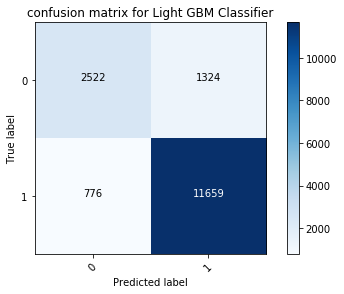

In [221]:
# 使用混淆图函数
types = ['0', '1']
plot_confusion_matrix(lgbm_confusion_matrix, classes=types, normalize=False,
                      title='confusion matrix for Light GBM Classifier')